The Notebook for training BERT base model on the dataset made by Filtering Comparative Questions from SQuAD and DROP dataset or any other dataset in the required format

In [ ]:
pip install transformers

In [ ]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

File ‘train-v2.0.json’ already there; not retrieving.

File ‘dev-v2.0.json’ already there; not retrieving.



In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_file = open('/content/drive/MyDrive/OELP_BERT/BERT_SQuad/combined_train_final.json')

new_data = json.load(dataset_file)

In [ ]:
num_q = 0
num_pos = 0
num_imp = 0
train_contexts = []
train_questions = []
train_answers = []
new_answers = []
new_answer_start = []

for i in range(len(new_data)):
  train_contexts.append(new_data[i]["sentence"])
  train_questions.append(new_data[i]['question'])
  new_answers.append(new_data[i]['answer'])
  new_answer_start.append(new_data[i]['answer_start'])
  train_answers.append({ 'text': new_answers[-1], 'answer_start': new_answer_start[-1]})

  num_q += 1
  if(0):
    num_imp += 1
  else:
    num_pos += 1

num_questions = num_q
num_posible = num_pos
num_impossible = num_imp


In [ ]:
print(f"numq is {num_q}")
print(f"num_pos is {num_pos}")
print(f"num_imp is {num_imp}")

numq is 3502
num_pos is 3502
num_imp is 0


In [ ]:
print(train_questions[0:10])
print(train_answers[0:10])

['When did Beyonce start becoming popular?', 'What areas did Beyonce compete in when she was growing up?', "When did Beyonce leave Destiny's Child and become a solo singer?", 'In what city and state did Beyonce  grow up? ', 'In which decade did Beyonce become famous?', 'In what R&B group was she the lead singer?', 'What album made her a worldwide known artist?', "Who managed the Destiny's Child group?", 'When did Beyoncé rise to fame?', "What role did Beyoncé have in Destiny's Child?"]
[{'text': 'in the late 1990s', 'answer_start': 269}, {'text': 'singing and dancing', 'answer_start': 207}, {'text': '2003', 'answer_start': 526}, {'text': 'Houston, Texas', 'answer_start': 166}, {'text': 'late 1990s', 'answer_start': 276}, {'text': "Destiny's Child", 'answer_start': 320}, {'text': 'Dangerously in Love', 'answer_start': 505}, {'text': 'Mathew Knowles', 'answer_start': 360}, {'text': 'late 1990s', 'answer_start': 276}, {'text': 'lead singer', 'answer_start': 290}]


In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 15375
Total number of Answerable questions: 9430
Total number of impossible questions: 5945


In [ ]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'from which countries did the norse originate?', 'from which countries did the norse originate?']
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]


In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:

print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles Crazy in Love and Baby Boy.
Question: When did Beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [ ]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the english name "normans" comes from the french words normans/normanz, plural of normant, modern french normand, which is itself borrowed from old low franconian nortmann "northman" or directly from old norse norðmaðr, latinized variously as nortmannus, normannus, or nordmannus (recorded in medieval latin, 9th century) to mean "norseman, viking".
Question: what is the original meaning of the word norman?
Answer: {'text': 'norseman, viking', 'answer_start': 331, 'answer_end': 347}


907


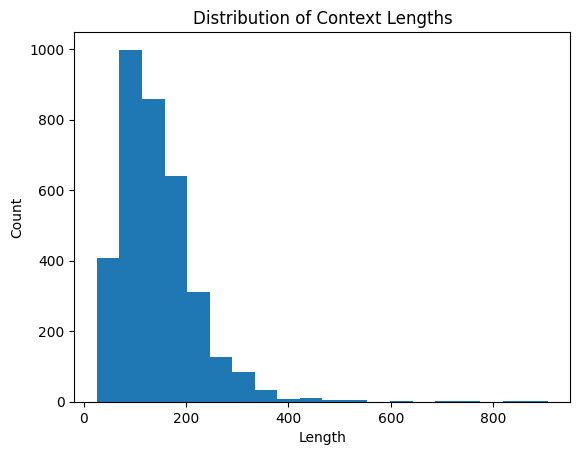

In [ ]:
token_lens = []

for txt in train_contexts:
    txt = txt.strip()
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

56
3502


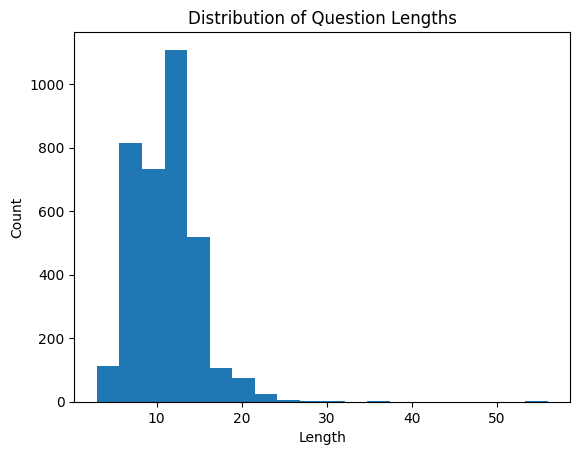

In [ ]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][1]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3502
250


In [ ]:
print(train_encodings_fast['input_ids'][1])
print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(train_encodings_fast['input_ids'][1])))

[101, 2054, 2752, 2106, 20773, 5566, 1999, 2043, 2016, 2001, 3652, 2039, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
0 0

split with luckett and rober
[CLS] what event caused beyonce's depression? [SEP] letoya luckett and roberson became unhappy with mathew's managing of the band and eventually were replaced by farrah franklin and michelle williams. beyonce experienced depression following the split with luckett and roberson after being publicly blamed by the media, critics, and blogs for its cause. her long - standing boyfriend left her at this time. the depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. beyonce stated that she struggled to speak about her depression because destiny's child had just won their first grammy award and she feared no one would take her seriously. beyonce would later speak of her mother as the person who helped her fight it. franklin was dismissed, leaving just beyonce, rowland, and williams. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
test_rec=1

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
68 71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles crazy in love and baby boy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3502


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

540


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3502


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

68
71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles crazy in love and baby boy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

393


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

france
france
[CLS] in what country is normandy located? [SEP] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
3502
3502
3502
20302
20302
20302


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

"[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles crazy in love and baby boy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

in the late 1990s


In [ ]:
answer_start_index = 0
answer_end_index = 100

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

"[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew"

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
batch_1 = 2
batch_2 = 2
dropout_val = 0.001
learnin_rate = 9*2e-6
weight_decay_val = 9*2e-3
no_of_epochs = 11

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=batch_1, shuffle=True)   #from 16 and 32 to 2 and 4
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_2)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

3502
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(dropout_val)    #changed from 0.1 to 0.2
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [ ]:
model = QAModel()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    return ((fl_start + fl_end)/2)

In [ ]:
optim = AdamW(model.parameters(), lr=learnin_rate, weight_decay=weight_decay_val)    #changed from 2e-5 to 2e-6 and from 2e-2 to 2e-3
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        #print(out_start)

        # for iter in range(16):
        #   print(tokenizerFast.decode(input_ids[iter]))

        # print(out_start.size())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        #print("\n")
        #print((type(start_positions)))
        #print(type(start_pred))

        # for iter in range(16):
        #   print("pred")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_pred[iter] : end_pred[iter]])))
        #   print("true ans")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_positions[iter] : end_positions[iter]])))

        #print(start_pred)
        #print(start_positions)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())

        #print(f"acc1 is {acc[-2]} acc2 is {acc[-1]}")
        #print("\n")

        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [ ]:
EPOCHS = no_of_epochs

model.to(device)
curr_epoch = 0
for epoch in range(EPOCHS):
    curr_epoch += 1
    print(f"current epoch is {curr_epoch}")
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

current epoch is 1


Running Epoch : 100%|██████████| 1751/1751 [03:35<00:00,  8.13it/s]


Train Accuracy: 0.4368932038834951      Train Loss: 2.11873659923745


Running Evaluation: 100%|██████████| 10151/10151 [05:49<00:00, 29.04it/s]


Validation Accuracy: 0.48524775884149346
current epoch is 2


Running Epoch : 100%|██████████| 1751/1751 [03:42<00:00,  7.88it/s]


Train Accuracy: 0.6866076527698458      Train Loss: 0.8502418120456623


Running Evaluation: 100%|██████████| 10151/10151 [05:51<00:00, 28.90it/s]


Validation Accuracy: 0.5020195054674417
current epoch is 3


Running Epoch : 100%|██████████| 1751/1751 [03:42<00:00,  7.88it/s]


Train Accuracy: 0.7925471159337522      Train Loss: 0.45170621054659954


Running Evaluation: 100%|██████████| 10151/10151 [05:50<00:00, 28.99it/s]


Validation Accuracy: 0.4881538764653729
current epoch is 4


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.89it/s]


Train Accuracy: 0.8349514563106796      Train Loss: 0.3060661618406196


Running Evaluation: 100%|██████████| 10151/10151 [05:51<00:00, 28.87it/s]


Validation Accuracy: 0.4787951925918629
current epoch is 5


Running Epoch : 100%|██████████| 1751/1751 [03:40<00:00,  7.93it/s]


Train Accuracy: 0.8692175899486008      Train Loss: 0.23756470023762077


Running Evaluation: 100%|██████████| 10151/10151 [05:50<00:00, 28.99it/s]


Validation Accuracy: 0.49665057629790166
current epoch is 6


Running Epoch : 100%|██████████| 1751/1751 [03:40<00:00,  7.93it/s]


Train Accuracy: 0.8923472301541976      Train Loss: 0.17727114768040517


Running Evaluation: 100%|██████████| 10151/10151 [05:50<00:00, 28.97it/s]


Validation Accuracy: 0.49857156930351687
current epoch is 7


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.91it/s]


Train Accuracy: 0.9066247858366647      Train Loss: 0.14509804058499864


Running Evaluation: 100%|██████████| 10151/10151 [05:50<00:00, 28.96it/s]


Validation Accuracy: 0.5010836370800906
current epoch is 8


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.91it/s]


Train Accuracy: 0.9249000571102227      Train Loss: 0.121558213819697


Running Evaluation: 100%|██████████| 10151/10151 [05:49<00:00, 29.04it/s]


Validation Accuracy: 0.47970643286375725
current epoch is 9


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.89it/s]


Train Accuracy: 0.9274700171330669      Train Loss: 0.10656259522838435


Running Evaluation: 100%|██████████| 10151/10151 [05:49<00:00, 29.06it/s]


Validation Accuracy: 0.5007634715791548
current epoch is 10


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.91it/s]


Train Accuracy: 0.9466019417475728      Train Loss: 0.0748632810551429


Running Evaluation: 100%|██████████| 10151/10151 [05:51<00:00, 28.91it/s]


Validation Accuracy: 0.5015515712737662
current epoch is 11


Running Epoch : 100%|██████████| 1751/1751 [03:41<00:00,  7.91it/s]


Train Accuracy: 0.953026841804683      Train Loss: 0.07538000241913517


Running Evaluation: 100%|██████████| 10151/10151 [05:50<00:00, 28.96it/s]

Validation Accuracy: 0.4718254359176436


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
scheduler.get_last_lr()

[5.648590729620001e-06]

In [ ]:
print(train_acc)

0.953026841804683


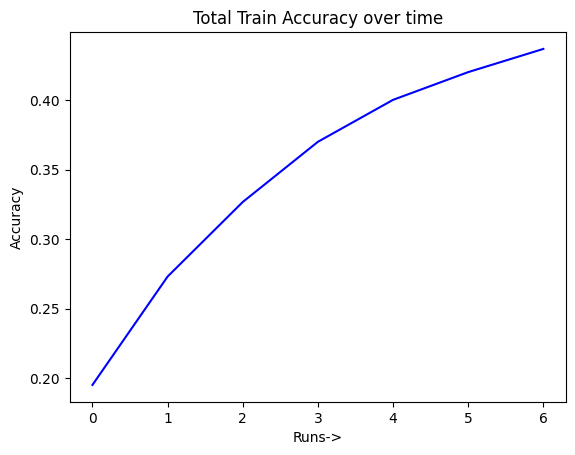

In [ ]:
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

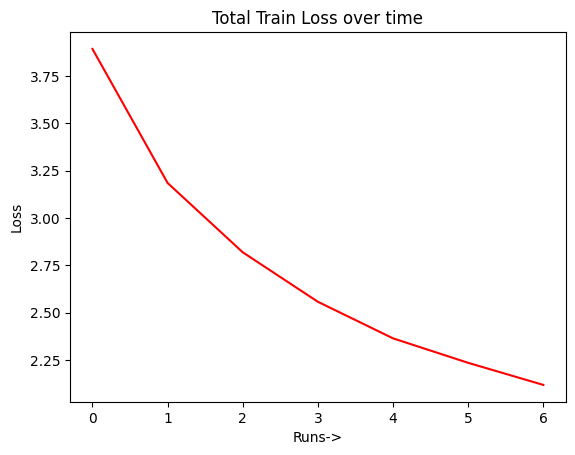

In [ ]:
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: in what country is normandy located?
Expected Answer: {'text': 'france', 'answer_start': 159, 'answer_end': 165}
Predicted Answer: france


In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: who was the norse leader?
Expected Answer: {'text': 'rollo', 'answer_start': 308, 'answer_end': 313}
Predicted Answer: rollo


In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the norman dynasty had a major political, cultural and military impact on medieval europe and even the near east. the normans were famed for their martial spirit and eventually for their christian piety, becoming exponents of the catholic orthodoxy into which they assimilated. they adopted the gallo-romance language of the frankish land they settled, their dialect becoming known as norman, normaund or norman french, an important literary language. the duchy of normandy, which they formed by treaty with the french crown, was a great fief of medieval france, and under richard i of normandy was forged into a cohesive and formidable principality in feudal tenure. the normans are noted both for their culture, such as their unique romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. norman adventurers founded the kingdom of sicily under roger ii after conquering southern italy on the saracens and byzantines, and an exped

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: as of august 2010, victoria had 1,548 public schools, 489 catholic schools and 214 independent schools. just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. over 61 per cent of private students attend catholic schools. more than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. victoria has about 63,519 full-time teachers.
Question: how many full time teachers does victoria have?
Expected Answer: {'text': '63,519', 'answer_start': 541, 'answer_end': 547}
Predicted Answer: 


In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: oxygen is more soluble in water than nitrogen is. water in equilibrium with air contains approximately 1 molecule of dissolved o
2 for every 2 molecules of n
2, compared to an atmospheric ratio of approximately 1:4. the solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·l−1) dissolves at 0 °c than at 20 °c (7.6 mg·l−1). at 25 °c and 1 standard atmosphere (101.3 kpa) of air, freshwater contains about 6.04 milliliters (ml) of oxygen per liter, whereas seawater contains about 4.95 ml per liter. at 5 °c the solubility increases to 9.0 ml (50% more than at 25 °c) per liter for water and 7.2 ml (45% more) per liter for sea water.
Question: how much oxygen is found is a liter of fresh water under normal conditions?
Expected Answer: {'text': '6.04 milliliters', 'answer_start': 441, 'answer_end': 457}
Predicted Answer: 


In [ ]:
context = "I am Utsav Patel. I just completed my fine-tuning of the BERT base uncased model. I am glad that it works after 5 attempts."
question = "How many attempts did it take to fine-tune ?"
print(f"Predicted Answer: {get_answer(question, context)}")

Predicted Answer: 5


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/OELP_BERT/BERT_SQuad/OELP_combined_v3.hdf5')

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')